In [1]:
import netCDF4 as nc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from windrose import WindroseAxes
import scipy.stats as stats
import glob

In [2]:
def get_wind_turbine_files(folder_path):
    return glob.glob(f"{folder_path}/kp.turbine.z02.b0.*.wt*.nc") # Get all the wts in the folder

In [3]:
def print_netcdf_structure(file_path):
    try:
        with nc.Dataset(file_path, 'r') as dataset:
            print(f"NetCDF File: {os.path.basename(file_path)}")
            print("\nGlobal Attributes:")
            for attr in dataset.ncattrs():
                print(f"  {attr}: {getattr(dataset, attr)}")

            print("\nDimensions:")
            for dim_name, dim in dataset.dimensions.items():
                print(f"  {dim_name}: {len(dim)}")

            print("\nVariables:")
            for var_name, var in dataset.variables.items():
                print(f"  {var_name}:")
                print(f"    Dimensions: {var.dimensions}")
                print(f"    Shape: {var.shape}")
                print(f"    Data type: {var.dtype}")
                print("    Attributes:")
                for attr in var.ncattrs():
                    print(f"      {attr}: {getattr(var, attr)}")

    except Exception as e:
        print(f"Error reading NetCDF file: {e}")

In [4]:
def create_df_from_netcdf(file_paths):
    dfs = []
    for file_path in file_paths:
        try:
            with nc.Dataset(file_path, 'r') as dataset:
                # Convert time to datetime
                time_var = dataset.variables['date']
                time = nc.num2date(time_var[:], time_var.units)
                time = pd.to_datetime([t.strftime('%Y-%m-%d %H:%M:%S') for t in time])

                data = {
                    'time': time,
                    'generator_current_phase_1': dataset.variables['WCNV.GnA1'][:],
                    'generator_current_phase_2': dataset.variables['WCNV.GnA2'][:],
                    'generator_current_phase_3': dataset.variables['WCNV.GnA3'][:],
                    'generator_voltage_phase_1': dataset.variables['WCNV.GnPNV1'][:],
                    'generator_voltage_phase_2': dataset.variables['WCNV.GnPNV2'][:],
                    'generator_voltage_phase_3': dataset.variables['WCNV.GnPNV3'][:],
                    'power_output': dataset.variables['WTUR.W'][:],
                    'turbine_availability': dataset.variables['WAVL.TurAvl'][:],
                    'generator_bearing_de_temp': dataset.variables['WGEN.BrgDETmp'][:],
                    'generator_bearing_nde_temp': dataset.variables['WGEN.BrgNDETmp'][:],
                    'generator_inlet_temp': dataset.variables['WGEN.InLetTmp'][:],
                    'generator_stator_temp_1': dataset.variables['WGEN.SttTmp1'][:],
                    'generator_stator_temp_2': dataset.variables['WGEN.SttTmp2'][:],
                    'generator_rotor_speed': dataset.variables['WGEN.RotSpd'][:],
                    'nacelle_direction': dataset.variables['WNAC.Dir'][:],
                    'nacelle_temperature': dataset.variables['WNAC.Tmp'][:],
                    'ambient_temperature': dataset.variables['WMET.EnvTmp'][:],
                    'blade_pitch_angle_1': dataset.variables['WROT.BlPthAngVal1'][:],
                    'blade_pitch_angle_2': dataset.variables['WROT.BlPthAngVal2'][:],
                    'blade_pitch_angle_3': dataset.variables['WROT.BlPthAngVal3'][:],
                    'rotor_speed': dataset.variables['WROT.RotSpd'][:],
                    'turbine_status': dataset.variables['WTUR.TurSt'][:],
                    'wind_direction': dataset.variables['WMET.HorWdDir'][:],
                    'wind_speed': dataset.variables['WMET.HorWdSpd'][:]
                }
                df = pd.DataFrame(data)
                df['turbine_id'] = os.path.basename(file_path).split('.')[-2]  # Extract turbine ID            
                df = df.groupby('time').agg({   # Group by timestamp and aggregate
                    col: 'first' for col in df.columns if col != 'time'
                }).reset_index()            
                dfs.append(df)
                print(f"Processed {file_path}, shape: {df.shape}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
                
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df.set_index(['turbine_id', 'time'], inplace=True)
        print(f"Combined DataFrame shape: {combined_df.shape}")
        print(f"Unique turbine IDs: {combined_df.index.get_level_values('turbine_id').unique()}")
        return combined_df
    else:
        print("No data frames were created.")
        return None

In [5]:
def filter_turbine_data(df, status_codes=None, availability_codes=None, include_nan=False):
    """
    status_codes (list): List of status codes to include (e.g., [1, 3])
    availability_codes (list): List of availability codes to include (e.g., [100, 50])
    include_nan (bool): Whether to include NaN values in the filter
    """
    filtered_df = df.copy()
    
    # Forward fill NaN values
    filtered_df['turbine_status'] = filtered_df['turbine_status'].ffill()
    filtered_df['turbine_availability'] = filtered_df['turbine_availability'].ffill()
    
    # Create masks for filtering
    status_mask = pd.Series(True, index=filtered_df.index)
    availability_mask = pd.Series(True, index=filtered_df.index)
    
    if status_codes is not None:
        status_mask = filtered_df['turbine_status'].isin(status_codes)
    
    if availability_codes is not None:
        availability_mask = filtered_df['turbine_availability'].isin(availability_codes)
    
    # Combine masks
    combined_mask = status_mask & availability_mask
    
    if include_nan:
        combined_mask |= (filtered_df['turbine_status'].isna() & filtered_df['turbine_availability'].isna())
    
    return filtered_df[combined_mask]


In [29]:
def plot_time_series(df, turbine_ids):
    if isinstance(turbine_ids, str):
        turbine_ids = [turbine_ids]  # Convert single ID to list
    
    available_turbines = df.index.get_level_values('turbine_id').unique()
    valid_turbines = [tid for tid in turbine_ids if tid in available_turbines]
    
    if not valid_turbines:
        print(f"Error: No valid turbine IDs")
        print("Available turbine IDs:", available_turbines)
        return
    
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    for turbine_id in valid_turbines:
        turbine_data = df.loc[turbine_id].reset_index()
        
        sns.lineplot(data=turbine_data, x='time', y='wind_speed', ax=ax1, label=f'{turbine_id} Wind Speed')
        sns.lineplot(data=turbine_data, x='time', y='power_output', ax=ax2, label=f'{turbine_id} Power Output')
    
    ax1.set_ylabel('Wind Speed (m/s)')
    ax2.set_ylabel('Power Output (kW)')
    ax2.set_xlabel('Time')
    
    ax1.set_title('Wind Speed Over Time', fontsize=14)
    ax2.set_title('Power Output Over Time', fontsize=14)
    
    fig.suptitle(f'Wind Speed and Power Output for Turbines: {", ".join(valid_turbines)}', fontsize=16)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_scatter_wind_speed_power(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='wind_speed', y='power_output')
    plt.title('Scatter Plot of Wind Speed vs Power Output')
    plt.xlabel('Wind Speed')
    plt.ylabel('Power Output')
    plt.show()

In [8]:
def plot_wind_rose(wind_direction, wind_speed):
    plt.figure(figsize=(10, 10))
    ax = WindroseAxes.from_ax()
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title('Wind Rose')
    plt.show()

In [9]:
def plot_temperature_distribution(df):
    temp_columns = [
        'generator_bearing_de_temp',
        'generator_bearing_nde_temp',
        'generator_inlet_temp',
        'generator_stator_temp_1',
        'generator_stator_temp_2',
        'nacelle_temperature',
        'ambient_temperature'
    ]
    
    plt.figure(figsize=(15, 10))
    for col in temp_columns:
        sns.histplot(df[col], bins=20, kde=True, label=col)
    
    plt.title('Temperature Distributions')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [10]:
def plot_heatmap_correlation(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Heatmap of Correlation Matrix')
    plt.show()

In [11]:
def plot_boxplot_wind_speed(df, turbine_id):
    # Select data for the specified turbine
    turbine_data = df.loc[turbine_id]
    
    # Extract hour from the time index
    turbine_data = turbine_data.reset_index()
    turbine_data['hour'] = turbine_data['time'].dt.hour
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=turbine_data, x='hour', y='wind_speed')
    plt.title(f'Wind Speed Distribution by Hour for Turbine {turbine_id}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Wind Speed (m/s)')
    plt.show()  

In [12]:
def plot_wind_speed_weibull(df):
    # Extract wind speed data
    wind_speeds = df['wind_speed'].dropna()

    # Fit Weibull distribution
    shape, loc, scale = stats.weibull_min.fit(wind_speeds, floc=0)

    # Create a range of wind speeds for the fitted distribution
    x = np.linspace(0, wind_speeds.max(), 100)
    y = stats.weibull_min.pdf(x, shape, loc, scale)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.histplot(wind_speeds, stat='density', kde=True, color='skyblue', label='Observed')
    plt.plot(x, y, 'r-', lw=2, label=f'Weibull (k={shape:.2f}, λ={scale:.2f})')
    
    plt.title('Wind Speed Distribution with Fitted Weibull', fontsize=16)
    plt.xlabel('Wind Speed (m/s)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    sns.despine()
    plt.show()

    print(f"Weibull shape parameter (k): {shape:.2f}")
    print(f"Weibull scale parameter (λ): {scale:.2f}")

**Main execution part**

In [13]:
folder_path = "../../awaken_data/"
file_path = folder_path + "kp.turbine.z02.b0.20220101.000000.wt001.nc"
file_paths = get_wind_turbine_files(folder_path)

In [36]:
# print(nc.Dataset(file_path, 'r'))

In [37]:
# print_netcdf_structure(file_path)

In [38]:
df = create_df_from_netcdf(file_paths)
# print(df.head())

Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt001.nc, shape: (41512, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt008.nc, shape: (42979, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt010.nc, shape: (41765, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt006.nc, shape: (40880, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt003.nc, shape: (43566, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt004.nc, shape: (43601, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt009.nc, shape: (40609, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt002.nc, shape: (44159, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt005.nc, shape: (43112, 26)
Processed ../../awaken_data/kp.turbine.z02.b0.20220101.000000.wt007.nc, shape: (44270, 26)
Combined DataFrame shape: (426453, 24)
Unique turbine IDs: Index(['wt001', 'wt008', 'wt010

In [40]:
filtered_df = filter_turbine_data(df, status_codes=[1], availability_codes=[100], include_nan=True)
# filtered_df = filtered_df.ffill()
# print(filtered_df.head(8))
print(f"Original shape: {df.shape}, Filtered shape: {filtered_df.shape}")

Original shape: (426453, 24), Filtered shape: (378769, 24)


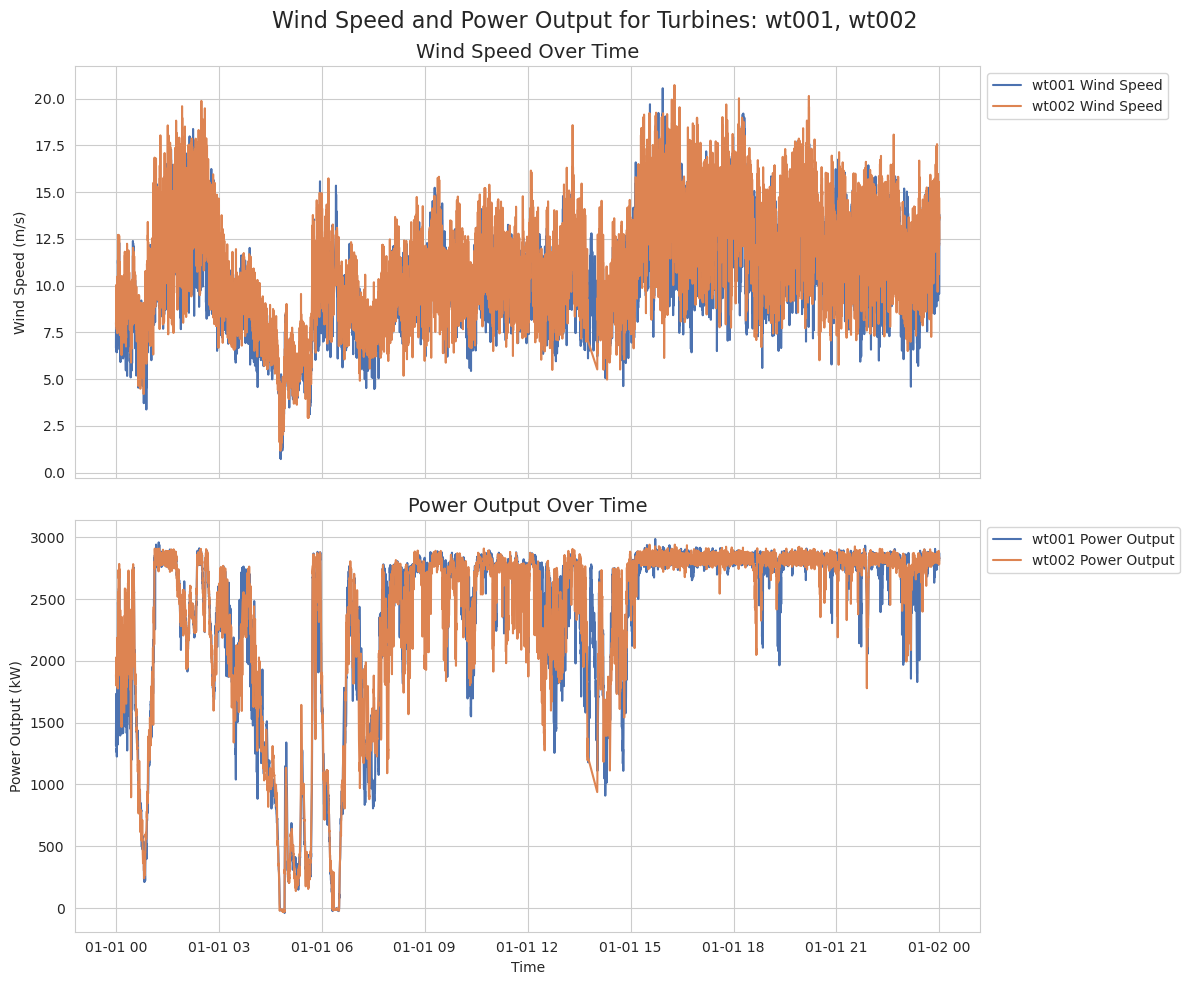

In [41]:
plot_time_series(filtered_df, ['wt001', 'wt002'])

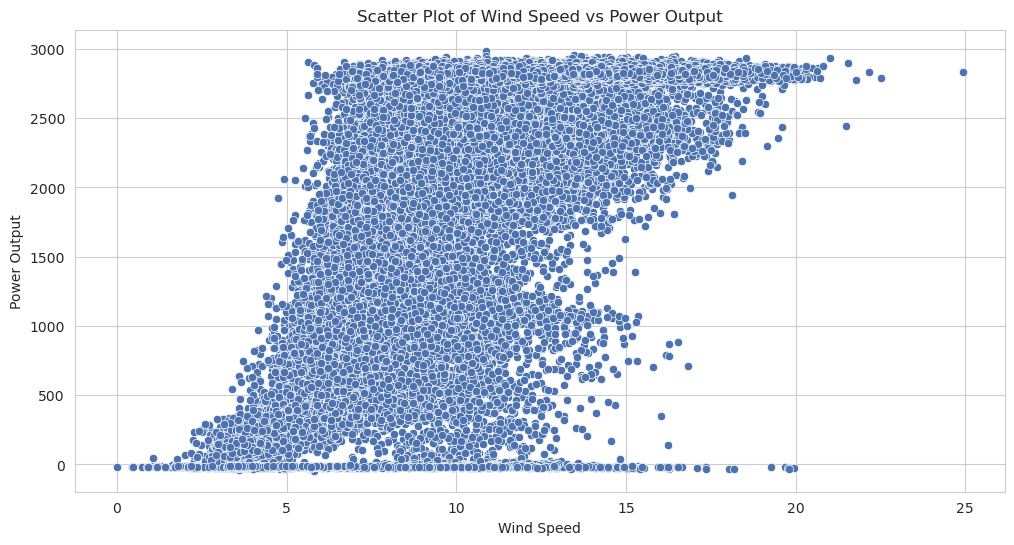

In [42]:
plot_scatter_wind_speed_power(filtered_df)

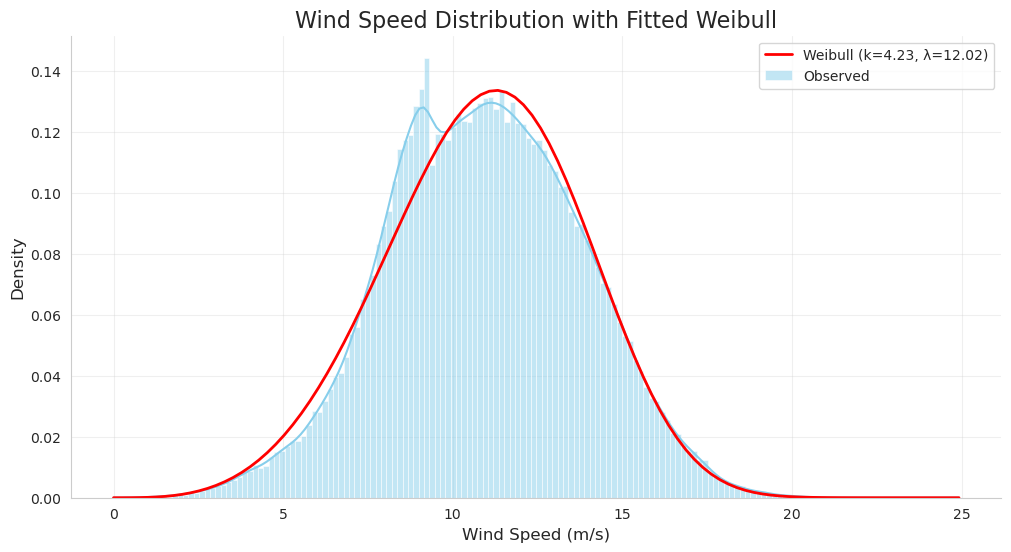

Weibull shape parameter (k): 4.23
Weibull scale parameter (λ): 12.02


In [43]:
plot_wind_speed_weibull(filtered_df)

<Figure size 1000x1000 with 0 Axes>

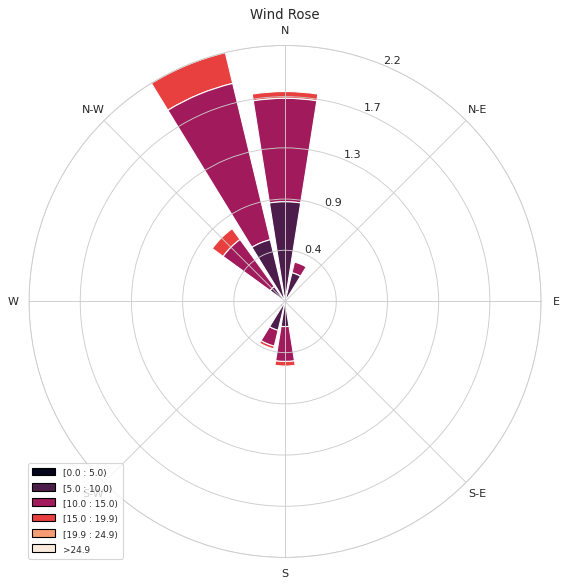

In [44]:
plot_wind_rose(filtered_df['wind_direction'], filtered_df['wind_speed'])

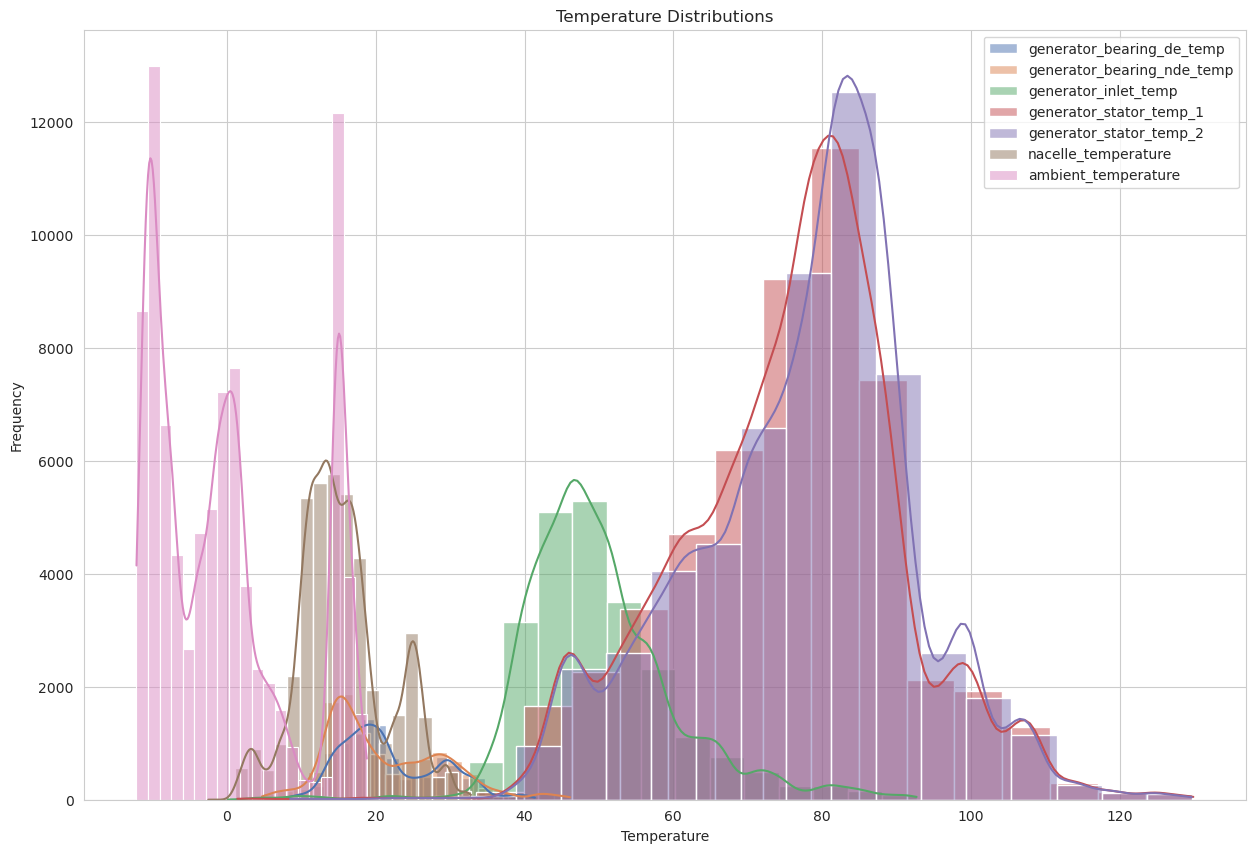

In [45]:
plot_temperature_distribution(filtered_df)

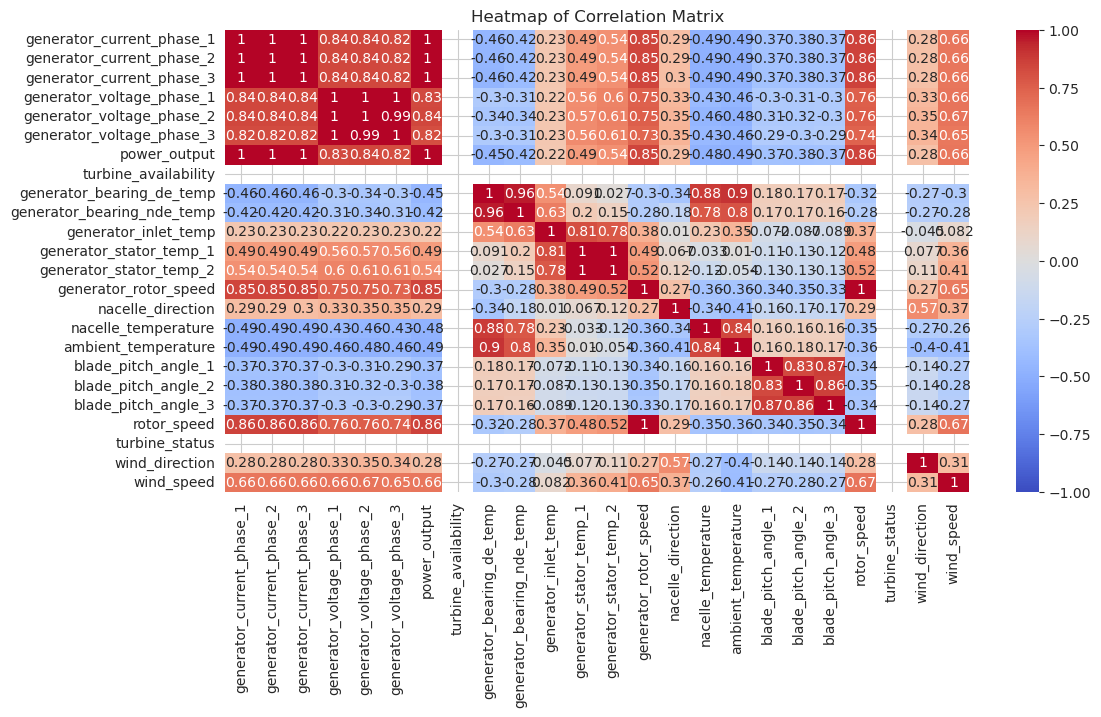

In [46]:
plot_heatmap_correlation(filtered_df)

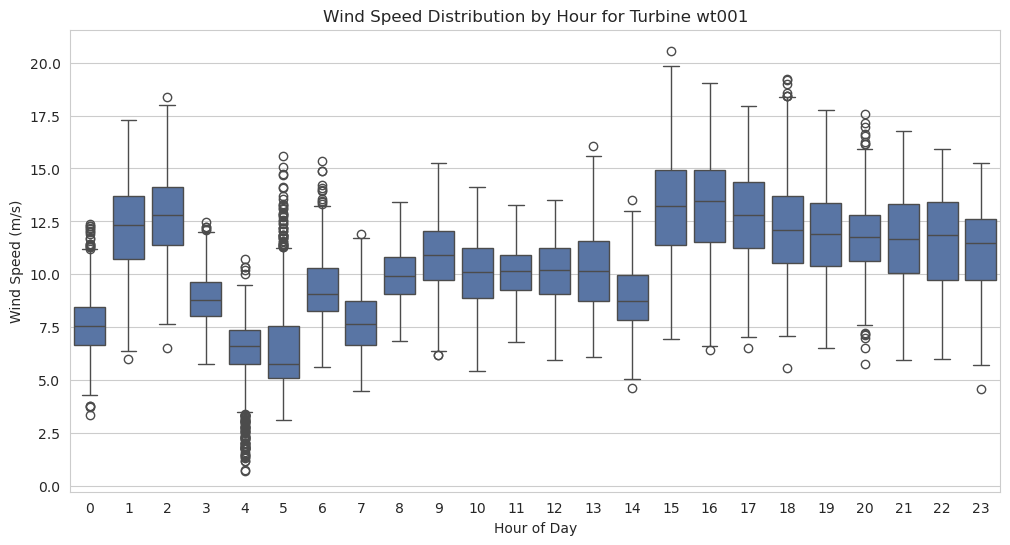

In [47]:
plot_boxplot_wind_speed(filtered_df, 'wt001')

In [25]:
print(df['wind_direction'].unique())
print("-"*100  )
print(df['turbine_status'].unique()) # 1: running, 3: not running
print(df['turbine_availability'].unique()) # 100, 50 (partially available?)


[188.  nan 183. 199. 204. 193. 197. 203. 196. 192. 191. 198. 184. 187.
 190. 182. 185. 177. 181. 178. 189. 172. 176. 179. 180. 194. 186. 173.
 165. 166. 171. 160. 169. 174. 170. 175. 168. 162. 164. 163. 167. 161.
 159. 201. 195. 205. 200. 208. 214. 216. 211. 213. 202. 209. 212. 207.
 227. 222. 206. 210. 215. 219. 220. 218. 217. 223. 224. 221. 225. 226.
 233. 228. 230. 138. 144. 267. 334. 318. 316. 290. 231. 247. 141. 252.
 261. 295. 266. 262. 241. 236. 238. 276. 272. 271. 275. 246. 248. 283.
 291. 292. 245. 237. 265. 288. 282. 306. 314. 300. 305. 277. 302. 299.
 325. 286. 287. 304. 307. 321. 322. 330. 289. 333. 346.   0.  10. 359.
 357. 352. 353. 350. 348. 343. 345. 340. 337. 339. 341. 331. 336. 335.
 338. 349. 347. 358. 356.   1.   7.   4.   2. 354.   5. 355.   6.   3.
  17. 351.  16.  13.   9. 344. 342.   8.  19.  14.  23.  24.  21.  20.
  28.  22.  32.  26.  34.  30.  33.  25.  35.  36.  39.  31.  29.  27.
  18.  15.  11.  49.  48.  50.  45.  43.  54.  51.  53.  47.  40.  44.
  57. 